In [1]:
import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '0'

# name of the synthetic directory
sim_name = 'canon_g1_ola_4fgl'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 11
svi_id = 300 # (24,25) =  (no outer roi, outer roi)
sim_seed = 1030
svi_seed = 0

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
ebin = 10
temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [4]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

/
    gp2temp_ebin10_svi_res_0.02_15000_mvn_8_1030_0.p
    summary.txt
    ebin10_svi_res_0.1_15000_mvn_8_1030_0.p
    gp2temp_ebin10_smp_svi_0.02_15000_mvn_8_1030_0.p
    __init__.py
    ebin10_smp_svi_0.1_15000_mvn_8_1030_0.p
    settings_7p1234567_5p23457_1p16_-1_11_300_1030_0.py
__pycache__/
    settings_7p1234567_5p23457_1p16_-1_11_300_1030_0.cpython-311.pyc


In [5]:
# load model using stored parameters

from models.poissonian_ed_amarel_customroi_4fgl import EbinPoissonModel # to set GPU at the beginning
from numpyro.infer import autoguide

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )
# configure model, run SVI, and generate samp 
ebinmodel.config_model(ebin=ebin)
ebinmodel.guide = autoguide.AutoMultivariateNormal(ebinmodel.model)
ebinmodel.init_svi(rng_key = jax.random.PRNGKey(0), optimizer = None, lr = 0.006, num_particles = 16, ebin = 10)
# ebinmodel.config_temp_model(params = svi_results.params)

(<numpyro.infer.svi.SVI at 0x7f21fc18c350>,
 SVIState(optim_state=(Array(0, dtype=int32, weak_type=True), ({'amp': Array(1.0986123, dtype=float32), 'auto_loc': Array([ 1.3101597 , -0.3444929 ,  0.9194803 ,  1.8499789 , -1.6922817 ,
         1.0707064 ,  1.8850722 , -0.32749796, -0.818377  ,  0.8917694 ,
        -1.1527457 , -1.5318198 , -1.8876357 , -1.1228962 , -1.5278449 ,
        -1.5507631 ,  0.59935856, -1.4718451 ,  1.5771623 ,  1.588726  ,
        -0.48119402, -0.14569902,  1.7269144 , -1.2273026 ,  0.12075424,
        -1.1494637 , -0.3676343 , -0.6052723 ,  0.9160018 , -1.8710208 ,
        -1.3583388 , -0.23215437, -1.7425623 ,  0.49188185, -1.3150172 ,
         1.1241927 ,  0.8085761 , -1.2033901 ,  1.4753113 ,  0.09211731,
        -1.0306983 ,  1.2372403 , -1.7611117 ,  0.700572  ,  0.9610162 ,
         1.4644156 ,  0.71567583,  0.11494637, -1.409276  , -0.25088787,
         0.90769005,  1.2849765 ,  0.630054  , -1.5473123 ,  1.0893774 ,
        -1.8592882 , -1.0109057 , -1.8

In [6]:
def truncate_samples(samples, n_samples):
    for key in samples.keys():
        samples[key] = samples[key][:n_samples]
    return samples

In [7]:
sim_seed = 1030

fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'

# load saved data from GP -> Data fit
fit_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

if is_gp:
    samples, svi_results, gp_samples = pickle.load(open(fit_dir + fit_file_name, 'rb'))
else:
    samples, svi_results = pickle.load(open(fit_dir + fit_file_name, 'rb'))

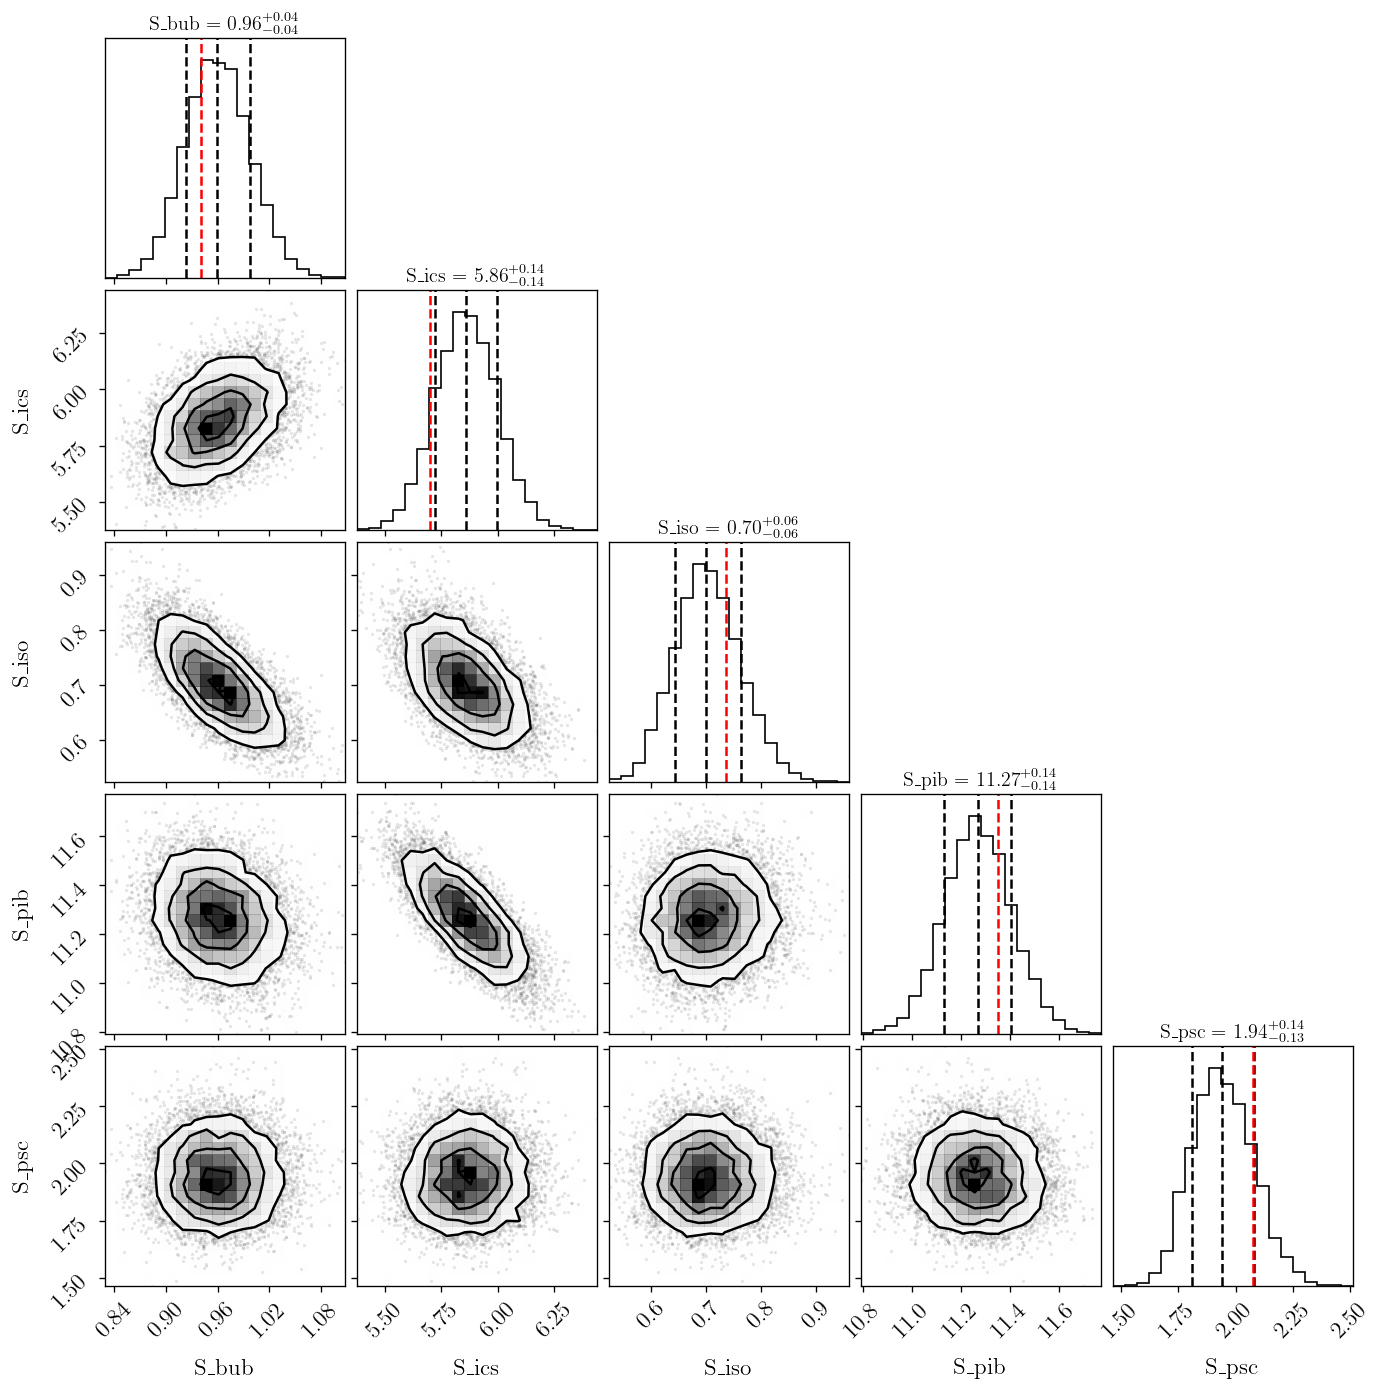

In [8]:
# gp fit background templates corner plot
fig = ef.make_corner_plots(samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)

100%|██████████| 405/405 [00:16<00:00, 24.67it/s]


Text(0.5, 0, 'step')

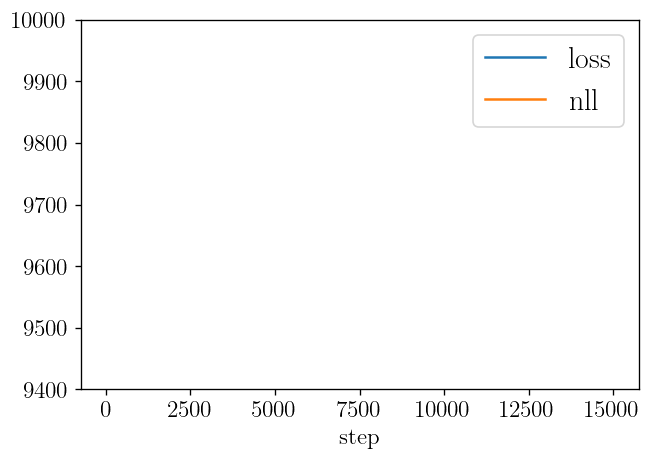

In [ ]:
# note requires predictive distribution, which was loaded two cells up
ebinmodel.predictive(ebinmodel.guide, num_samples = 1, params = svi_results.params)
ll_list = ebinmodel.recorded_log_likelihoods_1(num_samples = 16, svi_results = svi_results)
ll_list = jnp.array(ll_list)
losses = jnp.array(svi_results.losses)

In [ ]:
1000/15000
400*0.0666666666666

26.666666666639998

Text(0.5, 0, 'step')

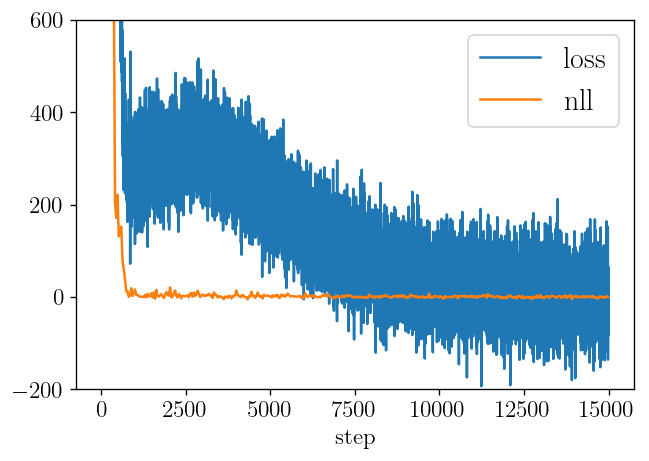

In [ ]:
plt.plot(losses - np.mean(losses[-1000:]), label = 'loss')
plt.plot(svi_results.recorded_steps, -ll_list-np.mean(-ll_list[-27:]), label = 'nll')
plt.ylim(-200,600)
plt.legend()
plt.xlabel('step')

In [ ]:
true_params = {}
true_params['S_nfw'] = temp_dict['S_nfw']
true_params['S_iso'] = temp_dict['S_iso']
true_params['S_blg'] = temp_dict['S_blg']
true_params['S_psc'] = temp_dict['S_psc']
true_params['S_bub'] = temp_dict['S_bub']
true_params['S_pib'] = temp_dict['S_pib']
true_params['S_ics'] = temp_dict['S_ics']
true_params['gamma'] = 1.
temp_q_list_norm = ebinmodel.recorded_quants(num_samples = 1000, normalized = True, true_temp_params=true_params, svi_results = svi_results)

100%|██████████| 405/405 [00:16<00:00, 23.84it/s]


(-2.0, 2.0)

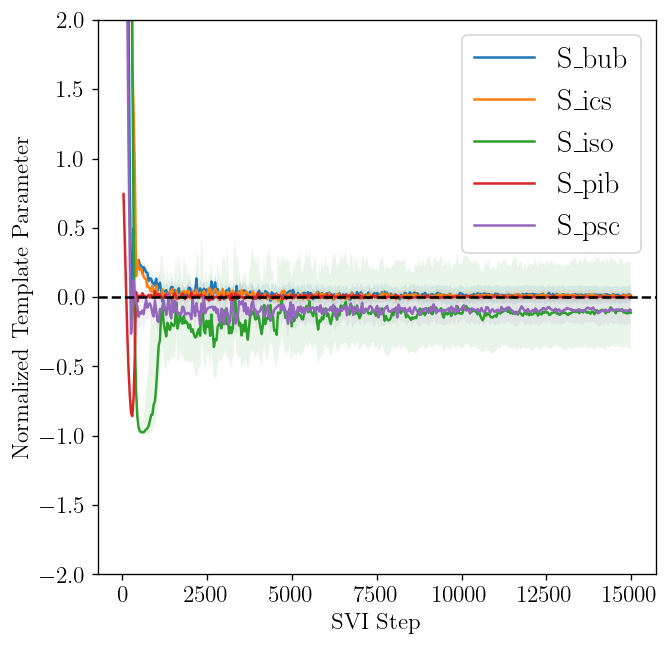

In [ ]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
for k in list(temp_q_list_norm[0].keys()):
    ax.plot(svi_results.recorded_steps, [temp_q_list_norm[j][k][1] for j in range(len(temp_q_list_norm))], label = k)
    ax.fill_between(svi_results.recorded_steps, [temp_q_list_norm[j][k][0] for j in range(len(temp_q_list_norm))], [temp_q_list_norm[j][k][2] for j in range(len(temp_q_list_norm))], alpha = 0.1)
ax.legend()
ax.set_xlabel('SVI Step')
ax.set_ylabel('Normalized Template Parameter')
ax.axhline(0, color = 'k', ls = '--', alpha = 1.)
ax.set_ylim([-2, 2])

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:02<00:00, 489.39it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 572.00it/s]


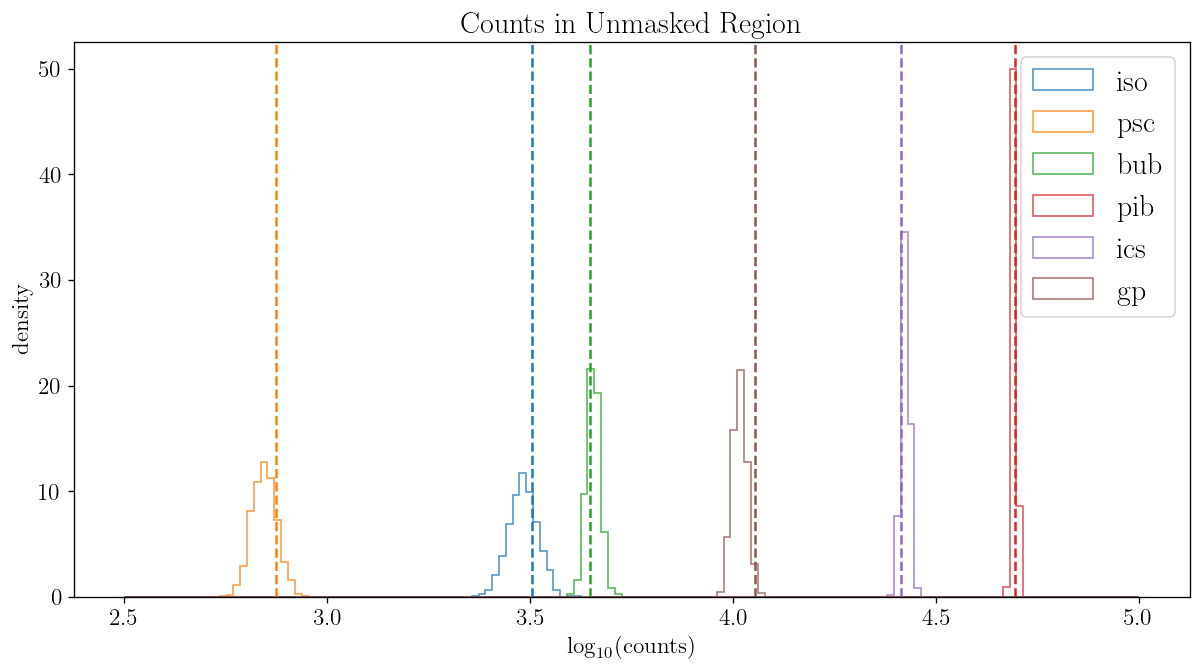

In [8]:
# generate samples and plot histograms of log counts

temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = gp_samples)
ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, bins = np.linspace(2.5,5.,150), gp_model_nfw=True, gp_model_iso = False)

/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon_4fgl/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon_4fgl/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


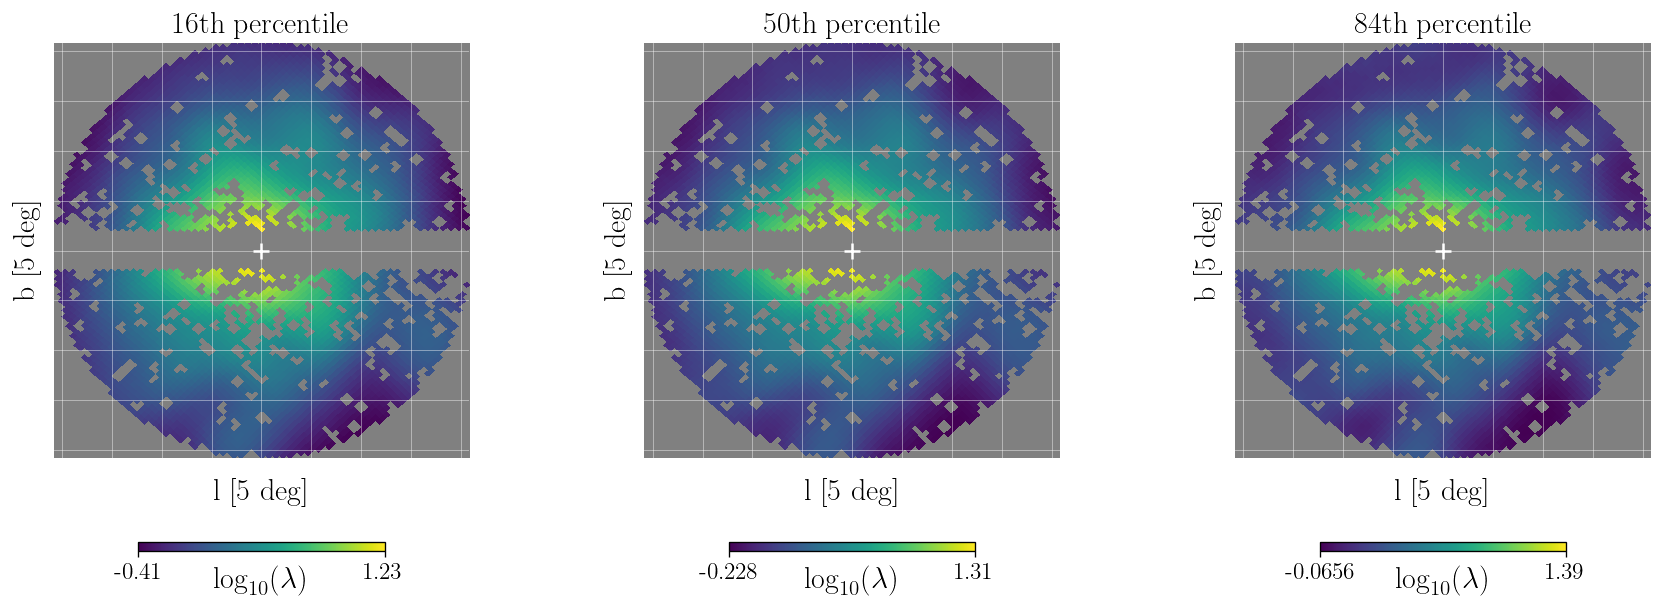

In [8]:
mask = ebinmodel.mask_roi_arr[10]
if is_gp:
    nside = ebinmodel.nside

    q = np.percentile(gp_samples, [16,50,84], axis = 0)

    titles = ['16th percentile', '50th percentile', '84th percentile']

    fig = plt.figure(figsize=(18, 6), dpi= 120)
    for i in range(3):
        map_p = ef.convert_masked_array_to_hp_array(np.exp(q[i]), mask, log_option = True, nside = 128)

        ax = fig.add_subplot(1,3,i+1)
        plt.axes(ax)
        title = titles[i]
        ef.gnomview_plot(map_p,title)
else:
    print('No GP Model, No GP Samples')

/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon_4fgl/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon_4fgl/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon_4fgl/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon_4fgl/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon_4fgl/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


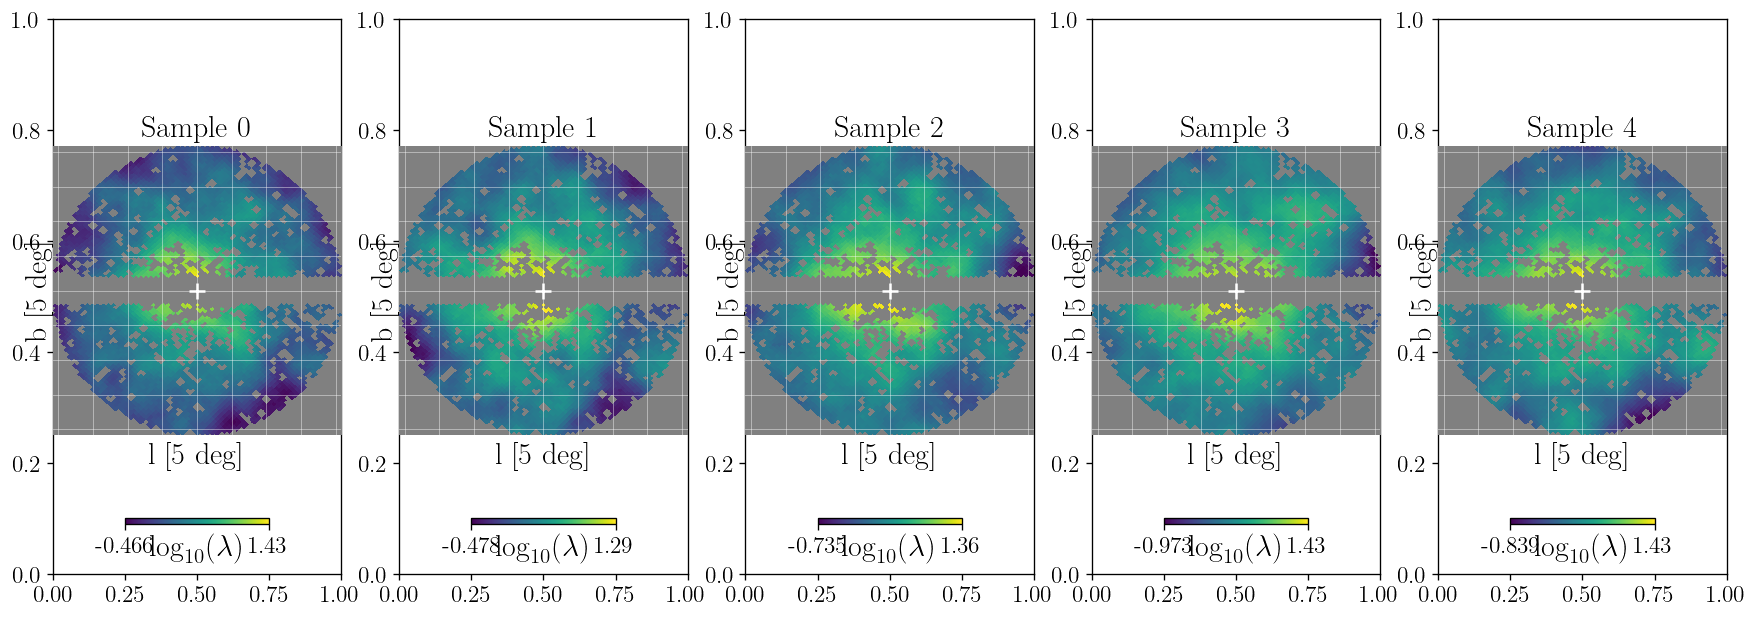

In [10]:
n_subplots = 5
fig, axes = plt.subplots(figsize=(18, 6), dpi= 120, nrows = 1, ncols = n_subplots)

for i in range(n_subplots):
    map_p = ef.convert_masked_array_to_hp_array(np.exp(gp_samples[i]), mask, log_option = True, nside = 128)
    ax = fig.add_subplot(1,n_subplots,i+1)
    plt.axes(ax)
    ef.gnomview_plot(map_p, 'Sample ' + str(i))



In [11]:
t = np.linspace(0, 2 * np.pi, 100)
l_list = 20. * np.cos(t)
b_list = 20. * np.sin(t)

inner_roi_x = 20. * np.cos(t)
inner_roi_y = 20. * np.sin(t)

outer_roi_low_x = 30. * np.cos(t)
outer_roi_low_y = 30. * np.sin(t)

outer_roi_high_x = 40. * np.cos(t)
outer_roi_high_y = 40. * np.sin(t)

outer_roi_lim_x = 80. * np.cos(t)
outer_roi_lim_y = 80. * np.sin(t)

In [12]:
inner_roi_x = np.deg2rad(inner_roi_x)
inner_roi_y = np.deg2rad(inner_roi_y)
outer_roi_low_x = np.deg2rad(outer_roi_low_x)
outer_roi_low_y = np.deg2rad(outer_roi_low_y)
outer_roi_high_x = np.deg2rad(outer_roi_high_x)
outer_roi_high_y = np.deg2rad(outer_roi_high_y)
outer_roi_lim_x = np.deg2rad(outer_roi_lim_x)
outer_roi_lim_y = np.deg2rad(outer_roi_lim_y)

/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon_4fgl/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


['dummy$^\\circ$', '-20.0$^\\circ$', '-10.0$^\\circ$', '0.0$^\\circ$', '10.0$^\\circ$', '20.0$^\\circ$']


/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(custom_xtick_labels, fontname=fontname)
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:630: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(custom_ytick_labels, fontname=fontname)


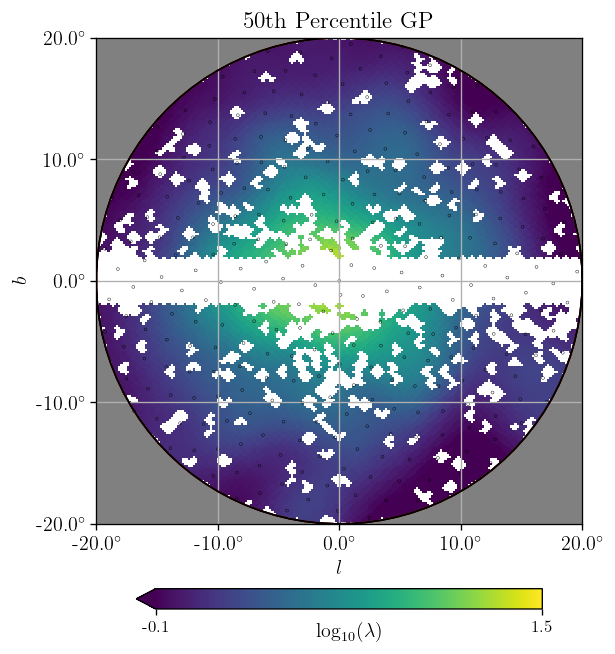

In [13]:
from healpy.newvisufunc import projview, newprojplot

fig = plt.figure(figsize=(6, 6))

nside = ebinmodel.nside
q = np.percentile(gp_samples, 50, axis = 0)

ie = ebin
mask_p = ebinmodel.mask_roi_arr[ie]
map_p = ef.convert_masked_array_to_hp_array(np.exp(q), mask_p, log_option = True, nside = 128)
m = map_p

s = '50th Percentile GP'
pre_xtick_labels = ['dummy', -20., -10., 0., 10., 20.]
xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
pre_ytick_labels = ['dummy', -20., -10., 0., 10., 20.]
ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]
print(xtick_labels)
projview(
    m,
    coord=["G"], 
    flip = "astro", 
    projection_type="cart", 
    title = s,
    xlabel = '$l$', 
    ylabel = '$b$', 
    xsize = 2000,
    latitude_grid_spacing = 10,
    longitude_grid_spacing = 10, 
    custom_xtick_labels=xtick_labels, 
    custom_ytick_labels=ytick_labels,
    graticule = True, 
    graticule_labels = True, 
    unit='$\log_{10}(\lambda)$',
    min = -0.1, max = 1.5,
    cb_orientation = 'horizontal', 
    override_plot_properties = {'cbar_pad': 0.1},
    hold = True
    )

plt.xlim(np.deg2rad(-20),np.deg2rad(20))
plt.ylim(np.deg2rad(-20),np.deg2rad(20))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="r", ls = "-", lw = 1.)

plt.xlim(np.deg2rad(-20),np.deg2rad(20))
plt.ylim(np.deg2rad(-20),np.deg2rad(20))
plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

plt.plot(inner_roi_x, inner_roi_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_low_x, outer_roi_low_y, color="k", ls = "-", lw = 1.)
plt.plot(outer_roi_high_x, outer_roi_high_y, color="k", ls = "-", lw = 1.)

annulus_roi_x = [inner_roi_x, outer_roi_low_x[::-1]]
annulus_roi_y = [inner_roi_y, outer_roi_low_y[::-1]]

plt.fill(np.ravel(annulus_roi_x), np.ravel(annulus_roi_y), color = 'gray')

xu_f = ebinmodel.xu_f
xu_f_r = np.deg2rad(xu_f)
plt.scatter(xu_f_r[:,0], xu_f_r[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

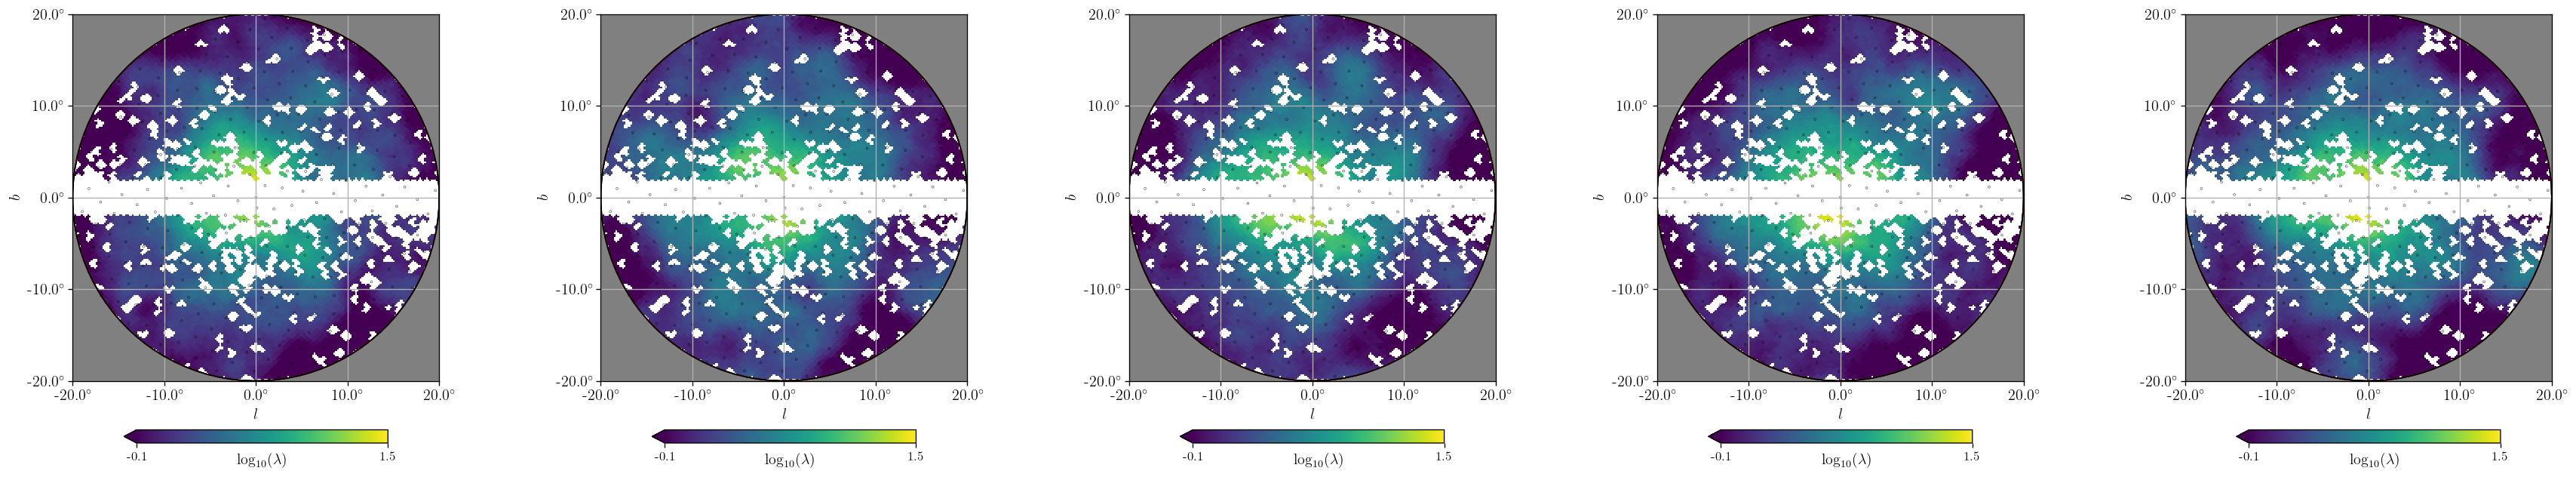

In [26]:
from healpy.newvisufunc import projview, newprojplot

nside = ebinmodel.nside

ie = ebin
mask_p = ebinmodel.mask_roi_arr[ie]

fig, axes = plt.subplots(figsize=(6*n_subplots, 6), dpi= 120, nrows = 1, ncols = n_subplots)
for n in range(n_subplots):
    map_p = ef.convert_masked_array_to_hp_array(np.exp(gp_samples[n]), mask_p, log_option = True, nside = 128)
    m = map_p

    s = '50th Percentile GP'
    pre_xtick_labels = ['dummy', -20., -10., 0., 10., 20.]
    xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
    pre_ytick_labels = ['dummy', -20., -10., 0., 10., 20.]
    ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]
    ax = axes[n]
    plt.axes(ax)
    projview(
        m,
        coord=["G"], 
        flip = "astro", 
        projection_type="cart", 
        # title = s,
        xlabel = '$l$', 
        ylabel = '$b$', 
        xsize = 2000,
        latitude_grid_spacing = 10,
        longitude_grid_spacing = 10, 
        custom_xtick_labels=xtick_labels, 
        custom_ytick_labels=ytick_labels,
        graticule = True, 
        graticule_labels = True, 
        unit='$\log_{10}(\lambda)$',
        min = -0.1, max = 1.5,
        cb_orientation = 'horizontal', 
        override_plot_properties = {'cbar_pad': 0.1},
        sub = int('1' + str(n_subplots) + str(n + 1)),
        hold = True,
        )

    plt.xlim(np.deg2rad(-20),np.deg2rad(20))
    plt.ylim(np.deg2rad(-20),np.deg2rad(20))
    plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="r", ls = "-", lw = 1.)

    plt.xlim(np.deg2rad(-20),np.deg2rad(20))
    plt.ylim(np.deg2rad(-20),np.deg2rad(20))
    plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

    plt.plot(inner_roi_x, inner_roi_y, color="k", ls = "-", lw = 1.)
    plt.plot(outer_roi_low_x, outer_roi_low_y, color="k", ls = "-", lw = 1.)
    plt.plot(outer_roi_high_x, outer_roi_high_y, color="k", ls = "-", lw = 1.)

    annulus_roi_x = [inner_roi_x, outer_roi_low_x[::-1]]
    annulus_roi_y = [inner_roi_y, outer_roi_low_y[::-1]]

    plt.fill(np.ravel(annulus_roi_x), np.ravel(annulus_roi_y), color = 'gray')

    xu_f = ebinmodel.xu_f
    xu_f_r = np.deg2rad(xu_f)
    plt.scatter(xu_f_r[:,0], xu_f_r[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

In [14]:
# 1D slice of GP posterior
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords(n_pixels = 160)

exp_gp_samples = np.exp(gp_samples)
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels=160, nside = 128)
q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0)

gp_temp_list = [temp for temp in ebinmodel.temp_names_sim if temp not in ebinmodel.temp_list]
gp_true = np.array([temp_dict[temp] for temp in gp_temp_list]).sum(axis = 0)
sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels=160, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=160, nside = 128)

100%|██████████| 1000/1000 [00:24<00:00, 41.28it/s]


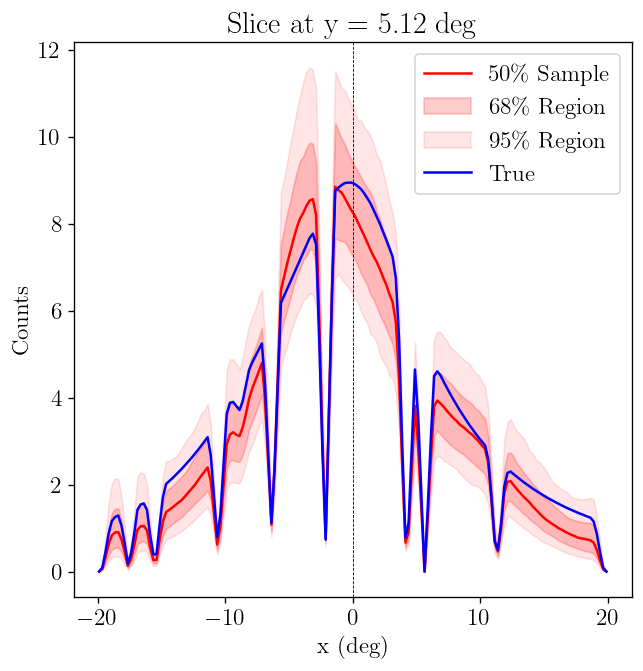

In [15]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 5.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.25 * res_scale)[0][1]

ax.plot(x[ny,:,0], q[2][ny,:], c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:], q[3][ny,:], color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:], q[4][ny,:], color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)

In [13]:
# 1D slice of GP posterior
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords(n_pixels = 160)

mask_map = np.zeros(gp_samples.shape[-1]) 
mask_map_cart = ef.healpix_to_cart(mask_map, mask, n_pixels=160, nside = 128, nan_fill = True) # doesn't matter what mask used
exp_gp_samples = np.exp(gp_samples)
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels=160, nside = 128)
q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0)

gp_temp_list = [temp for temp in ebinmodel.temp_names_sim if temp not in ebinmodel.temp_list]
gp_true = np.array([temp_dict[temp] for temp in gp_temp_list]).sum(axis = 0)
sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels=160, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=160, nside = 128)

100%|██████████| 1000/1000 [00:24<00:00, 41.26it/s]


In [15]:
res_scale = 1.
slice_val = 5.
y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.25 * res_scale)[0][1]
mask_map_cart_slice = mask_map_cart[ny,:]

print(mask_map_cart_slice)

[nan nan nan nan nan  0.  0. nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan
 nan nan nan nan nan  0. nan nan nan nan nan nan  0.  0.  0.  0. nan nan
 nan nan nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0. nan nan nan nan nan
 nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan nan nan nan
 nan nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan nan nan nan nan]


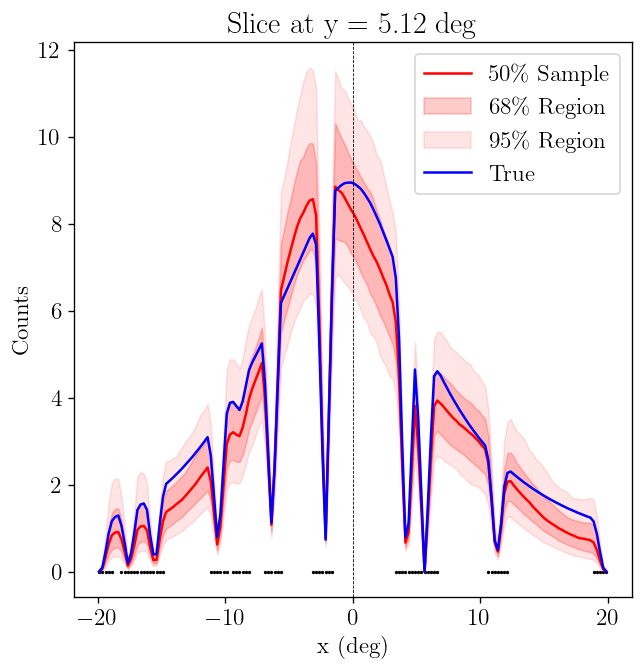

In [16]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 5.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.25 * res_scale)[0][1]

ax.plot(x[ny,:,0], q[2][ny,:], c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:], q[3][ny,:], color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:], q[4][ny,:], color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)

# fill points where mask_map_cart is nan
nan_mask = np.isnan(mask_map_cart_slice)
x_nan = x[ny,nan_mask,0]
y_nan = np.zeros_like(x_nan)
ax.scatter(x_nan, y_nan, c = 'k', s = 1)

# fill between points in x_nan that are separated by at most 0.5 deg
x_nan_diff = np.diff(x_nan)

(-0.25, 12.25)

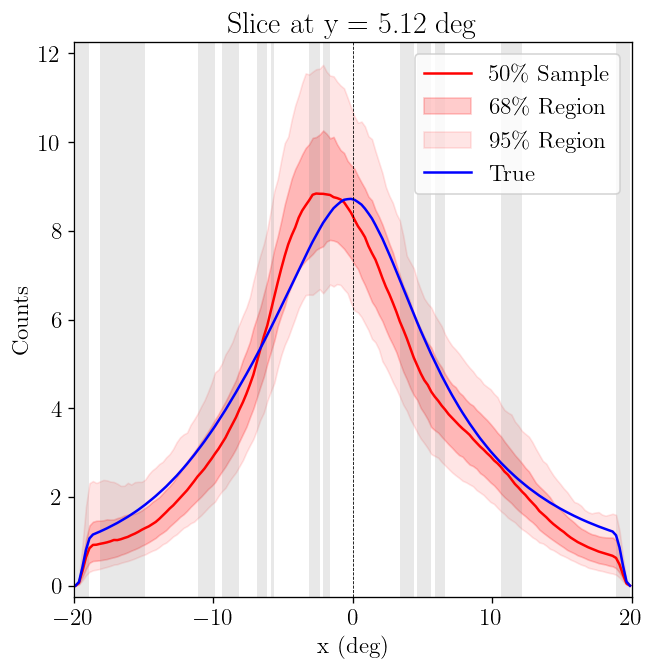

In [72]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 5.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.25 * res_scale)[0][1]

ax.plot(x[ny,:,0], q[2][ny,:], c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:], q[3][ny,:], color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:], q[4][ny,:], color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)

# fill points where mask_map_cart is nan
nan_mask = np.isnan(mask_map_cart_slice)
x_nan = x[ny,nan_mask,0]
y_nan = np.zeros_like(x_nan)
# ax.scatter(x_nan, y_nan, c = 'k', s = 1)

# fill between points in x_nan that are separated by at most 0.5 deg
x_nan_diff = np.diff(x_nan)

# find the indices of the x_nan_diff that are greater than 0.25 in order to 
# partition x_nan into separate arrays with members that are less than 0.25 separated

split_indices = np.where(x_nan_diff > 0.25)[0] + 1
split_indices = np.insert(split_indices, 0, 0)
split_indices = np.append(split_indices, len(x_nan))

for i in range(len(split_indices) - 1):
    x_fill = x_nan[split_indices[i]:split_indices[i+1]]
    y_fill = np.zeros_like(x_fill) - 1
    ax.fill_between(x_fill, y_fill, np.max(q[-1]) + 1, color = 'gray', alpha = 0.175, edgecolor = None)

ax.set_xlim(-20,20)
ax.set_ylim(-0.25, 12.25)

In [27]:
#  generate GP across unmasked ROI
from utils import create_mask as cm
mask = cm.make_mask_total(
        nside=128,
        mask_ring=True,
        outer = 20.,
        inner = 0.,
    )
ebinmodel.predictive(ebinmodel.guide, num_samples = 1, params = svi_results.params)
rng_key = jax.random.PRNGKey(19)
rng_key, key = jax.random.split(rng_key)
gp_samples = ebinmodel.cget_gp_samples_vec(key, 1000, svi_results, custom_mask = mask) #v3 (vectorized)

/data/edr76/gce-prob-prog-ed-v0.3/notebooks_canon_4fgl/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should o

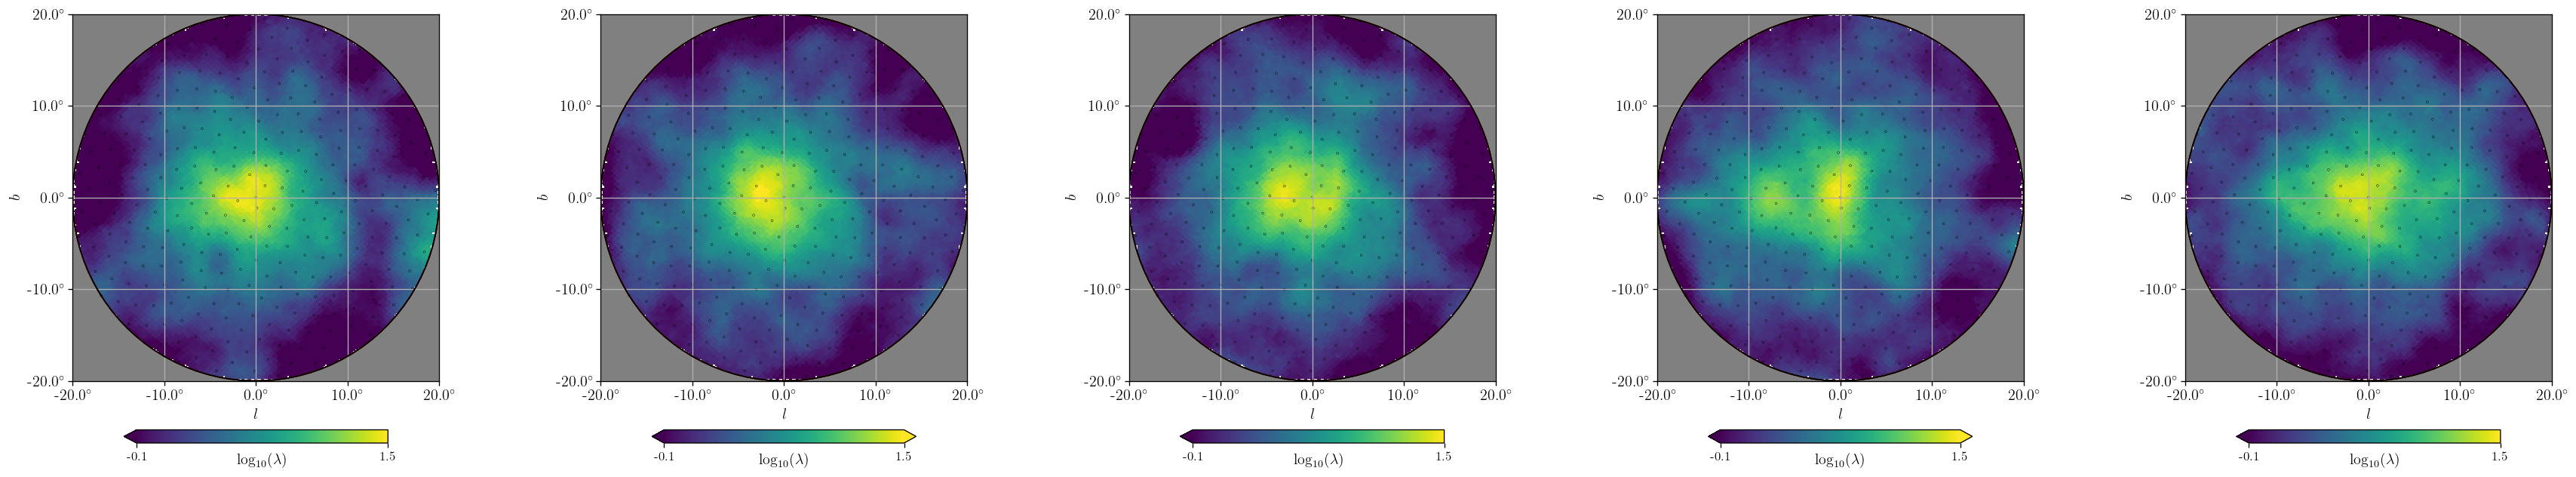

In [28]:
from healpy.newvisufunc import projview, newprojplot

nside = ebinmodel.nside

ie = ebin
mask_p = mask

fig, axes = plt.subplots(figsize=(6*n_subplots, 6), dpi= 120, nrows = 1, ncols = n_subplots)
for n in range(n_subplots):
    map_p = ef.convert_masked_array_to_hp_array(np.exp(gp_samples[n]), mask_p, log_option = True, nside = 128)
    m = map_p

    s = '50th Percentile GP'
    pre_xtick_labels = ['dummy', -20., -10., 0., 10., 20.]
    xtick_labels = [str(i) + '$^\circ$' for i in pre_xtick_labels]
    pre_ytick_labels = ['dummy', -20., -10., 0., 10., 20.]
    ytick_labels = [str(i) + '$^\circ$' for i in pre_ytick_labels]
    ax = axes[n]
    plt.axes(ax)
    projview(
        m,
        coord=["G"], 
        flip = "astro", 
        projection_type="cart", 
        # title = s,
        xlabel = '$l$', 
        ylabel = '$b$', 
        xsize = 2000,
        latitude_grid_spacing = 10,
        longitude_grid_spacing = 10, 
        custom_xtick_labels=xtick_labels, 
        custom_ytick_labels=ytick_labels,
        graticule = True, 
        graticule_labels = True, 
        unit='$\log_{10}(\lambda)$',
        min = -0.1, max = 1.5,
        cb_orientation = 'horizontal', 
        override_plot_properties = {'cbar_pad': 0.1},
        sub = int('1' + str(n_subplots) + str(n + 1)),
        hold = True,
        )

    plt.xlim(np.deg2rad(-20),np.deg2rad(20))
    plt.ylim(np.deg2rad(-20),np.deg2rad(20))
    plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="r", ls = "-", lw = 1.)

    plt.xlim(np.deg2rad(-20),np.deg2rad(20))
    plt.ylim(np.deg2rad(-20),np.deg2rad(20))
    plt.plot(np.deg2rad(l_list), np.deg2rad(b_list), color="k", ls = "-", lw = 1.)

    plt.plot(inner_roi_x, inner_roi_y, color="k", ls = "-", lw = 1.)
    plt.plot(outer_roi_low_x, outer_roi_low_y, color="k", ls = "-", lw = 1.)
    plt.plot(outer_roi_high_x, outer_roi_high_y, color="k", ls = "-", lw = 1.)

    annulus_roi_x = [inner_roi_x, outer_roi_low_x[::-1]]
    annulus_roi_y = [inner_roi_y, outer_roi_low_y[::-1]]

    plt.fill(np.ravel(annulus_roi_x), np.ravel(annulus_roi_y), color = 'gray')

    xu_f = ebinmodel.xu_f
    xu_f_r = np.deg2rad(xu_f)
    plt.scatter(xu_f_r[:,0], xu_f_r[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

In [52]:
# 1D slice of GP posterior
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords(n_pixels = 160)

mask_map = np.zeros((~ebinmodel.mask_roi_arr[ebin]).sum())
mask_map_cart = ef.healpix_to_cart(mask_map, ebinmodel.mask_roi_arr[ebin], n_pixels=160, nside = 128, nan_fill = True) # doesn't matter what mask used
exp_gp_samples = np.exp(gp_samples)
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels=160, nside = 128)
q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0)

# create gp_true from scratch
ebinmodel.load_templates(temp_names_sim, blg_names, dif_names)
gp_true = ( temp_dict['S_blg'] * ebinmodel.blg_temps[0].at_bin(ebin, mask) + temp_dict['S_nfw'] * ebinmodel.temps['nfw'].at_bin(ebin, mask) )
sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels=160, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=160, nside = 128)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:23<00:00, 42.00it/s]


In [53]:
res_scale = 1.
slice_val = 5.
y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.25 * res_scale)[0][1]
mask_map_cart_slice = mask_map_cart[ny,:]

print(mask_map_cart_slice)

[nan nan nan nan nan  0.  0. nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan
 nan nan nan nan nan  0. nan nan nan nan nan nan  0.  0.  0.  0. nan nan
 nan nan nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0. nan nan nan nan nan
 nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan nan nan nan
 nan nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan nan nan nan nan]


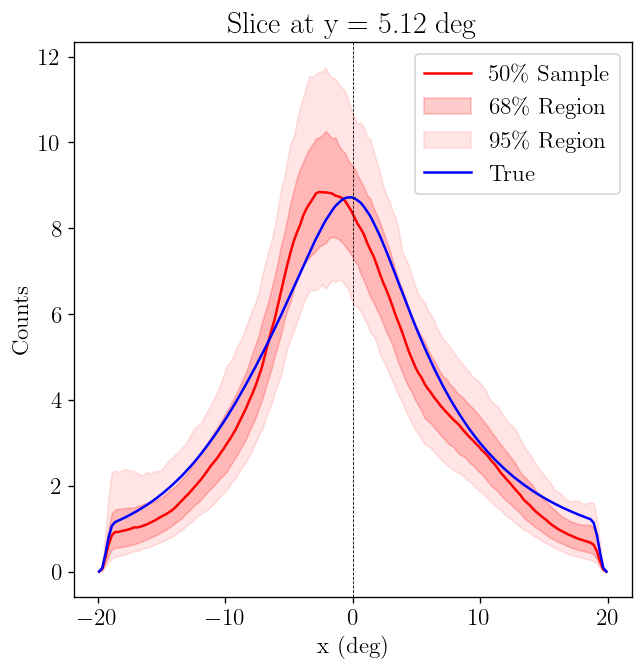

In [54]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 5.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.25 * res_scale)[0][1]

ax.plot(x[ny,:,0], q[2][ny,:], c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:], q[3][ny,:], color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:], q[4][ny,:], color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)

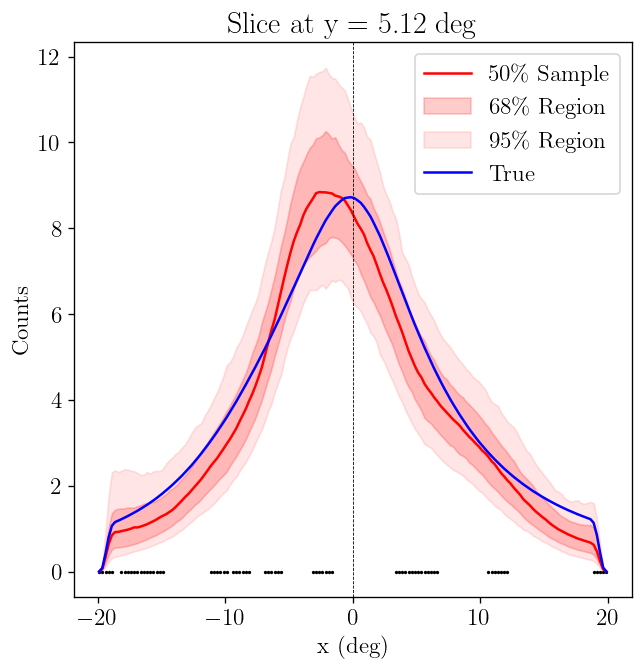

In [55]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 5.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.25 * res_scale)[0][1]

ax.plot(x[ny,:,0], q[2][ny,:], c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:], q[3][ny,:], color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:], q[4][ny,:], color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)

# fill points where mask_map_cart is nan
nan_mask = np.isnan(mask_map_cart_slice)
x_nan = x[ny,nan_mask,0]
y_nan = np.zeros_like(x_nan)
ax.scatter(x_nan, y_nan, c = 'k', s = 1)

# fill between points in x_nan that are separated by at most 0.5 deg
x_nan_diff = np.diff(x_nan)

(-0.25, 12.25)

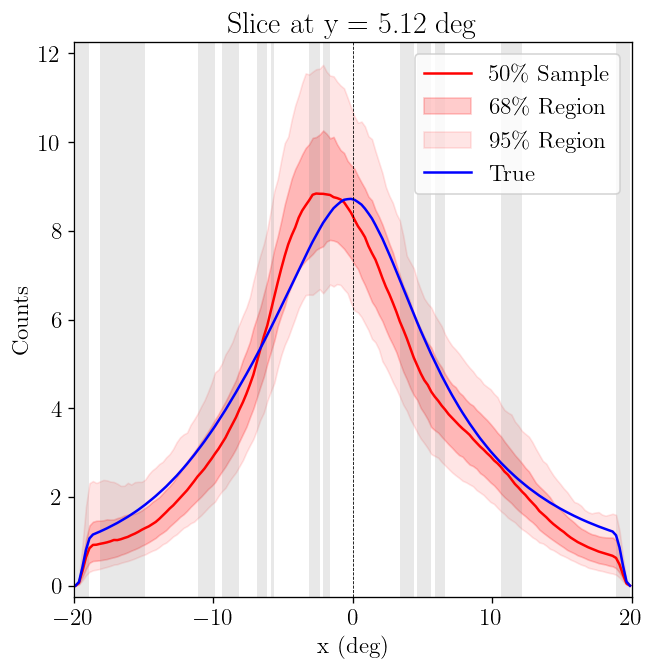

In [71]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 5.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.25 * res_scale)[0][1]

ax.plot(x[ny,:,0], q[2][ny,:], c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:], q[3][ny,:], color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:], q[4][ny,:], color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)

# fill points where mask_map_cart is nan
nan_mask = np.isnan(mask_map_cart_slice)
x_nan = x[ny,nan_mask,0]
y_nan = np.zeros_like(x_nan)
# ax.scatter(x_nan, y_nan, c = 'k', s = 1)

# fill between points in x_nan that are separated by at most 0.5 deg
x_nan_diff = np.diff(x_nan)

# find the indices of the x_nan_diff that are greater than 0.25 in order to 
# partition x_nan into separate arrays with members that are less than 0.25 separated

split_indices = np.where(x_nan_diff > 0.25)[0] + 1
split_indices = np.insert(split_indices, 0, 0)
split_indices = np.append(split_indices, len(x_nan))

for i in range(len(split_indices) - 1):
    x_fill = x_nan[split_indices[i]:split_indices[i+1]]
    y_fill = np.zeros_like(x_fill) - 1
    ax.fill_between(x_fill, y_fill, np.max(q[-1]) + 1, color = 'gray', alpha = 0.175, edgecolor = None)

ax.set_xlim(-20,20)
ax.set_ylim(-0.25, 12.25)

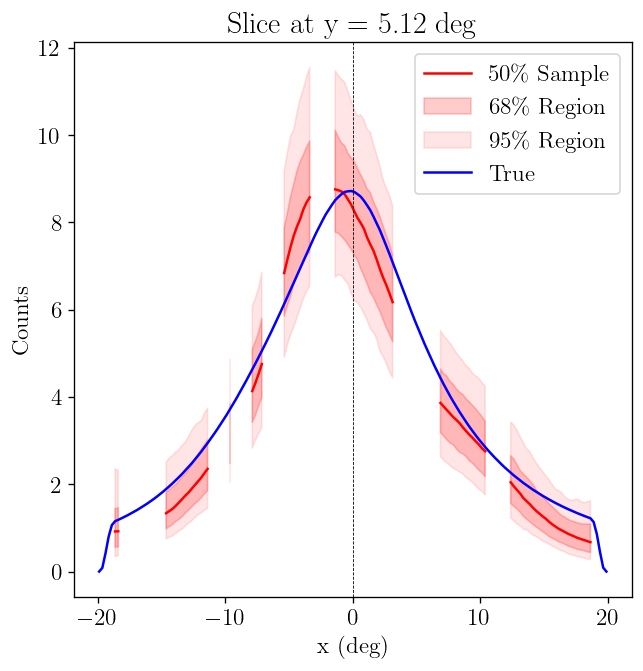

In [57]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 5.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.25 * res_scale)[0][1]

unit_map_cart_slice = np.exp(mask_map_cart_slice)
ax.plot(x[ny,:,0], q[2][ny,:] * unit_map_cart_slice, c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:] * unit_map_cart_slice, q[3][ny,:] * unit_map_cart_slice, color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:] * unit_map_cart_slice, q[4][ny,:] * unit_map_cart_slice, color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)

In [ ]:
# load settings of gp2temp
ebin = 10
str_ebin = str(ebin)

guide = 'mvn'
str_guide = guide

n_steps = 15000
str_n_steps = str(n_steps)

lr = 0.02  
str_lr = str(lr)   # BE SURE TO CHANGE THIS

num_particles = 8
str_num_particles = str(num_particles)

svi_seed = 0
str_svi_seed = str(svi_seed)

file_name = ('gp2temp_' + 'ebin' + str_ebin + '_smp_svi_' + 
        str_lr + '_' + str_n_steps + '_' + 
            str_guide + '_' + str_num_particles + '_' + 
            str_sim_seed + '_' + str_svi_seed + '.p')

temp_samples, svi_results = pickle.load(open(fit_dir + file_name, 'rb'))

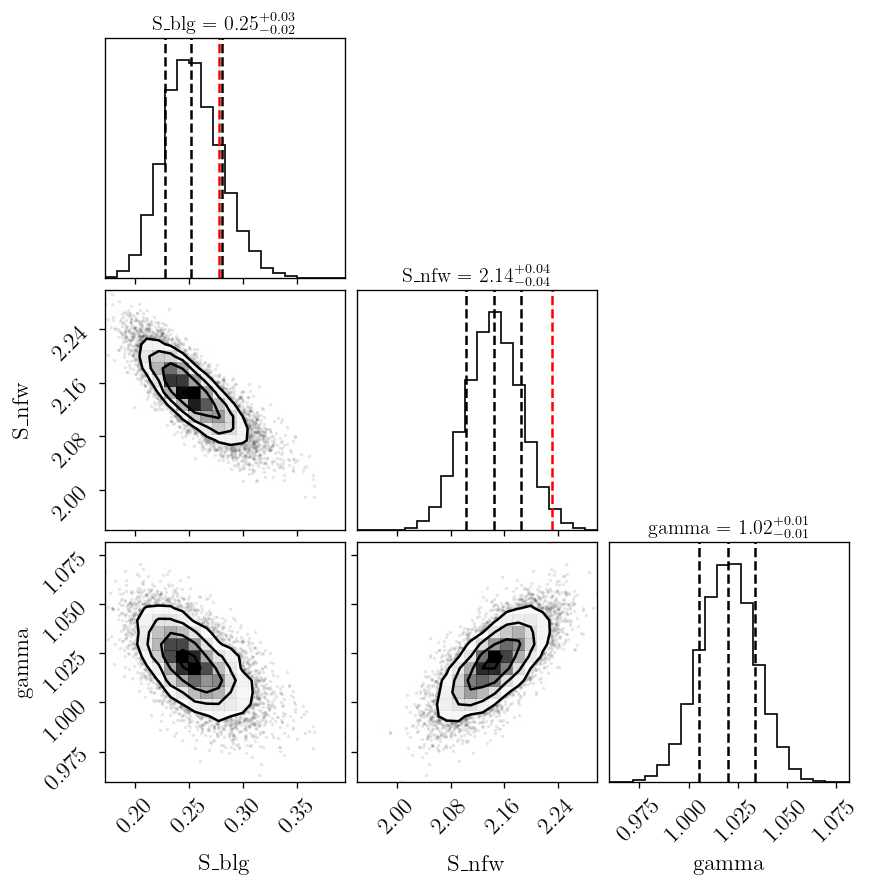

In [ ]:
# gp fit background templates corner plot
fig = ef.make_corner_plots(temp_samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)

In [22]:
# 1D slice of GP posterior
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords()

exp_gp_samples = np.exp(gp_samples)
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels=80, nside = 128)
q = np.percentile(exp_gp_samples_cart, [2.5,16,50,84,97.5], axis = 0)

gp_temp_list = [temp for temp in ebinmodel.temp_names_sim if temp not in ebinmodel.temp_list]
gp_true = np.array([temp_dict[temp] for temp in gp_temp_list]).sum(axis = 0)
sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels=80, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 138.45it/s]


In [23]:
ebinmodel.mask_ps_arr.shape

(40, 196608)

In [24]:
print(ebinmodel.counts[10][mask_p].shape)

(192302,)


In [25]:
x_mask = ef.get_x_from_mask(~mask_p, nside = 128)
print(x_mask.shape)

(192302, 2)


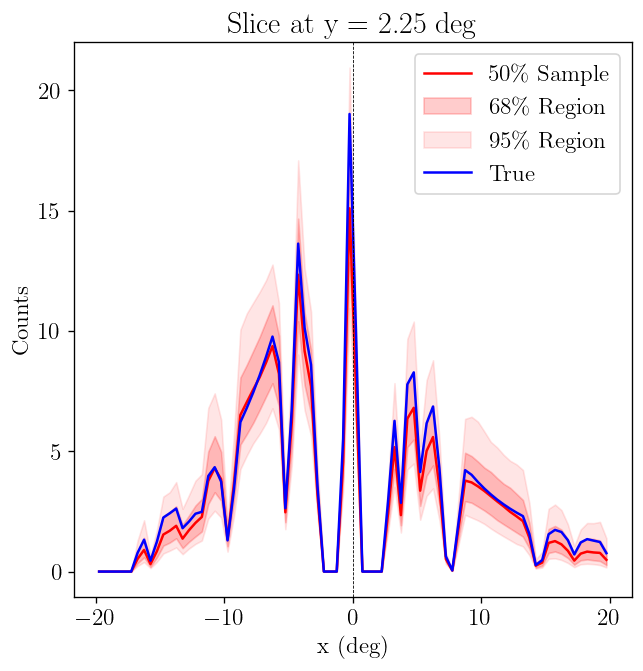

In [26]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 2.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.5 * res_scale)[0][1]

ax.plot(x[ny,:,0], q[2][ny,:], c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:], q[3][ny,:], color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:], q[4][ny,:], color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)


In [ ]:
# find how many pixels in x_mask are within 0.5 deg from a pixel in x
# return the number of pixels in x_mask that are within 0.5 deg from a pixel in x
# using the max distance (square)

def count_masked_pixels(x, x_mask, distance = 0.5):
    return np.sum(np.linalg.norm(x - x_mask, ord = np.inf, axis = -1) < distance)

In [ ]:
x_slice = x[ny,:,0]
masked_pix_count_arr = []
for x_pix in tqdm(x_slice):
    masked_pix_count_arr.append(count_masked_pixels(x_pix, x_mask, distance = 0.5))
masked_pix_count_arr = np.array(masked_pix_count_arr)

100%|██████████| 80/80 [00:00<00:00, 105.60it/s]


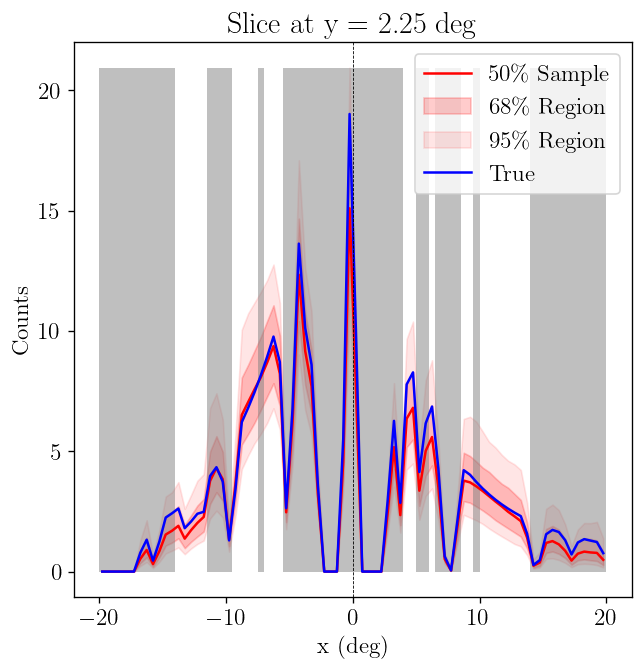

In [ ]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 2.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.5 * res_scale)[0][1]

ax.plot(x[ny,:,0], q[2][ny,:], c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:], q[3][ny,:], color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:], q[4][ny,:], color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)

# using masked_pix_count_arr, gray out the regions where the number of pixels within 0.5 deg with alpha proportional to counts

for x_pix, masked_pix_count in zip(x_slice, masked_pix_count_arr):
    x_bounds = np.array([x_pix - 0.25, x_pix + 0.25])
    y_low = np.array([0, 0])
    y_high = np.array([np.max(q[-1][ny,:]), np.max(q[-1][ny,:])])
    ax.fill_between(x_bounds, y_low, y_high, color = 'gray', alpha = 0.5 * np.min([1., masked_pix_count]), edgecolor = 'none')
    # remove outline from fill_between
    

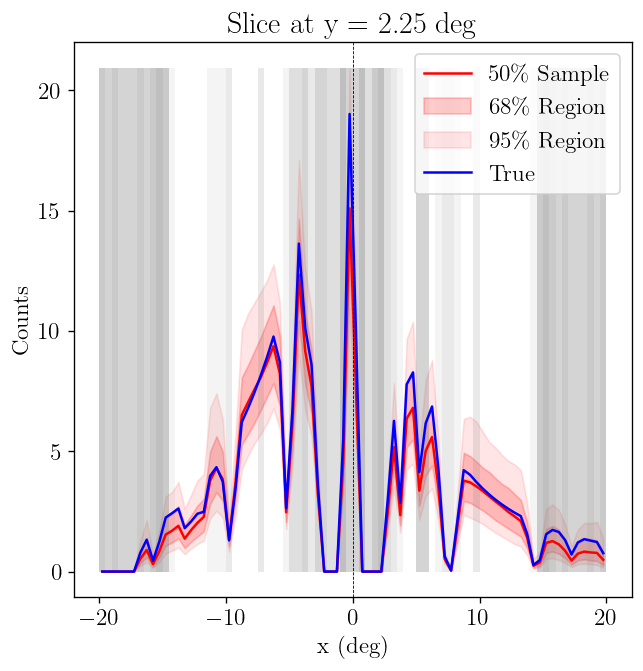

In [ ]:
res_scale = 1.
yscale = 'linear'
blg_coord = sim_cart
sim_coord = None
slice_val = 2.

fig = plt.figure(figsize=(6, 6), dpi= 120)

ax = fig.add_subplot(111)

y_slice = slice_val
ny = np.where(np.abs(x2_c - y_slice) < 0.5 * res_scale)[0][1]

ax.plot(x[ny,:,0], q[2][ny,:], c = 'red', label = '50\% Sample')
ax.fill_between(x[ny,:,0], q[1][ny,:], q[3][ny,:], color = 'red', alpha = 0.2, label = '68\% Region')
ax.fill_between(x[ny,:,0], q[0][ny,:], q[4][ny,:], color = 'red', alpha = 0.1, label = '95\% Region')
ax.plot(x[ny,:,0], blg_coord[ny,:], c = 'blue', label = 'True')
if sim_coord is not None:
    ax.errorbar(x[ny,:,0], sim_coord[ny,:], fmt = 'o', c = 'k', alpha = 0.5)
ax.set_xlabel('x (deg)')
ax.set_ylabel('Counts')
ax.set_title('Slice at y = {:.2f} deg'.format(x[ny,0,1]))
ax.legend(fontsize = 14)
ax.axvline(0, color='k', ls = '--', lw = 0.5)
ax.set_yscale(yscale)

# using masked_pix_count_arr, gray out the regions where the number of pixels within 0.5 deg with alpha proportional to counts

for x_pix, masked_pix_count in zip(x_slice, masked_pix_count_arr):
    x_bounds = np.array([x_pix - 0.25, x_pix + 0.25])
    y_low = np.array([0, 0])
    y_high = np.array([np.max(q[-1][ny,:]), np.max(q[-1][ny,:])])
    ax.fill_between(x_bounds, y_low, y_high, color = 'gray', alpha = 0.5 * np.max([0., masked_pix_count / masked_pix_count_arr.max()]), edgecolor = 'none')
    # remove outline from fill_between
    